<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/FXPROBOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the required libraries

In [ ]:
!pip install yfinance --user

In [11]:
import requests
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from termcolor import colored as cl
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')

# Data Extraction

In [22]:
#read data
df = pd.read_csv('/content/drive/MyDrive/data/eurusd30.csv', parse_dates=True)
# #setting index as date because some statsmodels might not work
df.index = pd.to_datetime(df['Time'])
print(len(df))
df.head()

122736


,Time,Open,High,Low,Close,Volume
Time,,,,,,
2010-01-01 00:00:00,2010-01-01 00:00:00,1.432840,1.432940,1.432265,1.432840,5.721000e+08
2010-01-01 00:30:00,2010-01-01 00:30:00,1.432825,1.432985,1.432340,1.432785,5.253000e+08
2010-01-01 01:00:00,2010-01-01 01:00:00,1.432885,1.432955,1.432090,1.432870,5.663000e+08
2010-01-01 01:30:00,2010-01-01 01:30:00,1.432735,1.433035,1.432135,1.432655,4.402000e+08
2010-01-01 02:00:00,2010-01-01 02:00:00,1.432900,1.433030,1.432295,1.432860,5.386000e+08


# Add RSI, MACD, CCI indicators to df

In [23]:
# constants
data_window = 1000
macd_slow = 26
macd_fast = 12
macd_smooth = 9
cci_ct = 0.015 #CCI = (AveP - SMA_of_AveP) / (0.015 * Mean Deviation)
cci_period = 20
rsi_period = 14

def get_macd(df, slow, fast, smooth):
    exp1 = df['Close'].ewm(span = fast, adjust = False).mean()
    exp2 = df['Close'].ewm(span = slow, adjust = False).mean()
    exp1_8 = df['Close'].ewm(span = fast*8, adjust = False).mean()
    exp2_8 = df['Close'].ewm(span = slow*8, adjust = False).mean()
    # 30Mn MACD
    df['macd'] = pd.DataFrame(exp1 - exp2)
    df['signal']  = pd.DataFrame(df['macd'].ewm(span = smooth, adjust = False).mean())
    df['hist'] = pd.DataFrame(df['macd'] - df['signal'])
    # 4Hour MACD
    df['macd8'] = pd.DataFrame(exp1_8 - exp2_8)
    df['signal8']  = pd.DataFrame(df['macd8'].ewm(span = smooth, adjust = False).mean())
    df['hist8'] = pd.DataFrame(df['macd8'] - df['signal8'])
    return df

def get_cci(df, n, constant): 
    TP = (df['High'] + df['Low'] + df['Close']) / 3 
    #moving_avg = ts_log.rolling(12).mean()
    CCI = pd.Series((TP - TP.rolling(n).mean()) / (constant * TP.rolling(n).std()), name = 'CCI_' + str(n)) 
    return CCI

def get_rsi(df, lookback):
    ret = df['Close'].diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(df['Close'].index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df = get_macd(df, macd_slow, macd_fast, macd_smooth)
df['cci'] = get_cci(df, cci_period, cci_ct)
df['rsi'] = get_rsi(df, rsi_period)

sample_df = df.tail(data_window)
sample_df

,Time,Open,High,Low,Close,Volume,macd,signal,hist,macd8,signal8,hist8,cci,rsi
Time,,,,,,,,,,,,,,
2016-12-11 04:00:00,2016-12-11 04:00:00,1.05599,1.05599,1.05599,1.05599,0.0,-0.000004,-0.000007,0.000002,-0.003733,-0.003785,0.000052,-inf,45.646387
2016-12-11 04:30:00,2016-12-11 04:30:00,1.05599,1.05599,1.05599,1.05599,0.0,-0.000004,-0.000006,0.000002,-0.003718,-0.003771,0.000053,-inf,45.646387
2016-12-11 05:00:00,2016-12-11 05:00:00,1.05599,1.05599,1.05599,1.05599,0.0,-0.000004,-0.000006,0.000002,-0.003703,-0.003758,0.000055,-inf,45.646387
2016-12-11 05:30:00,2016-12-11 05:30:00,1.05599,1.05599,1.05599,1.05599,0.0,-0.000003,-0.000005,0.000002,-0.003687,-0.003744,0.000056,-inf,45.646387
2016-12-11 06:00:00,2016-12-11 06:00:00,1.05599,1.05599,1.05599,1.05599,0.0,-0.000003,-0.000005,0.000002,-0.003672,-0.003729,0.000057,-inf,45.646387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 21:30:00,2016-12-31 21:30:00,1.05150,1.05150,1.05150,1.05150,0.0,-0.000049,-0.000071,0.000022,0.001790,0.001846,-0.000056,-inf,37.655468
2016-12-31 22:00:00,2016-12-31 22:00:00,1.05150,1.05150,1.05150,1.05150,0.0,-0.000045,-0.000066,0.000020,0.001776,0.001832,-0.000056,-inf,37.655468
2016-12-31 22:30:00,2016-12-31 22:30:00,1.05150,1.05150,1.05150,1.05150,0.0,-0.000042,-0.000061,0.000019,0.001763,0.001818,-0.000055,-inf,37.655468


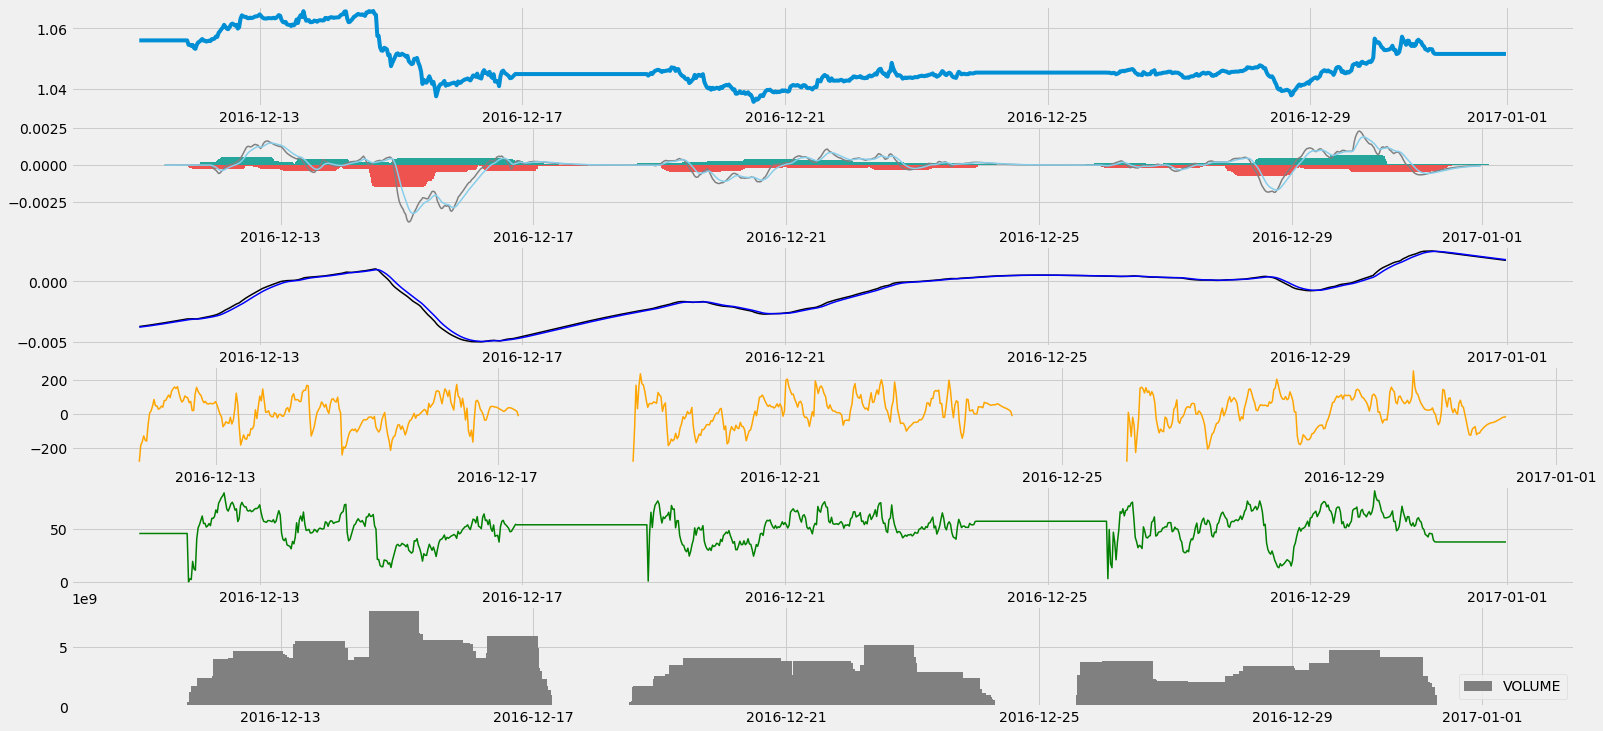

In [24]:
# Plot MACD
def plot_macd(prices, df):
    ax_price = plt.subplot2grid((6,1), (0,0),  colspan = 1)
    ax_macd = plt.subplot2grid((6,1), (1,0), colspan = 1)
    ax_macd8 = plt.subplot2grid((6,1), (2,0), colspan = 1)
    ax_cci = plt.subplot2grid((6,1), (3,0), colspan = 1)
    ax_rsi = plt.subplot2grid((6,1), (4,0), colspan = 1)
    ax_volume = plt.subplot2grid((6,1), (5,0), colspan = 1)

    ax_price.plot(prices)
    ax_macd.plot(df['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
    ax_macd.plot(df['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    ax_macd8.plot(df['macd8'], color = 'black', linewidth = 1.5, label = 'MACD8')
    ax_macd8.plot(df['signal8'], color = 'blue', linewidth = 1.5, label = 'SIGNAL8')
    ax_cci.plot(df['cci'], color = 'orange', linewidth = 1.5, label = 'CCI')
    ax_rsi.plot(df['rsi'], color = 'green', linewidth = 1.5, label = 'RSI')
    ax_volume.bar(prices.index, df['Volume'], color = 'grey', label = 'VOLUME')


    for i in range(len(prices)):
        if str(df['hist'][i])[0] == '-':
            ax_macd.bar(prices.index[i], df['hist'][i], color = '#ef5350')
        else:
            ax_macd.bar(prices.index[i], df['hist'][i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(sample_df['Close'], sample_df)

# Training and Validation Datasets

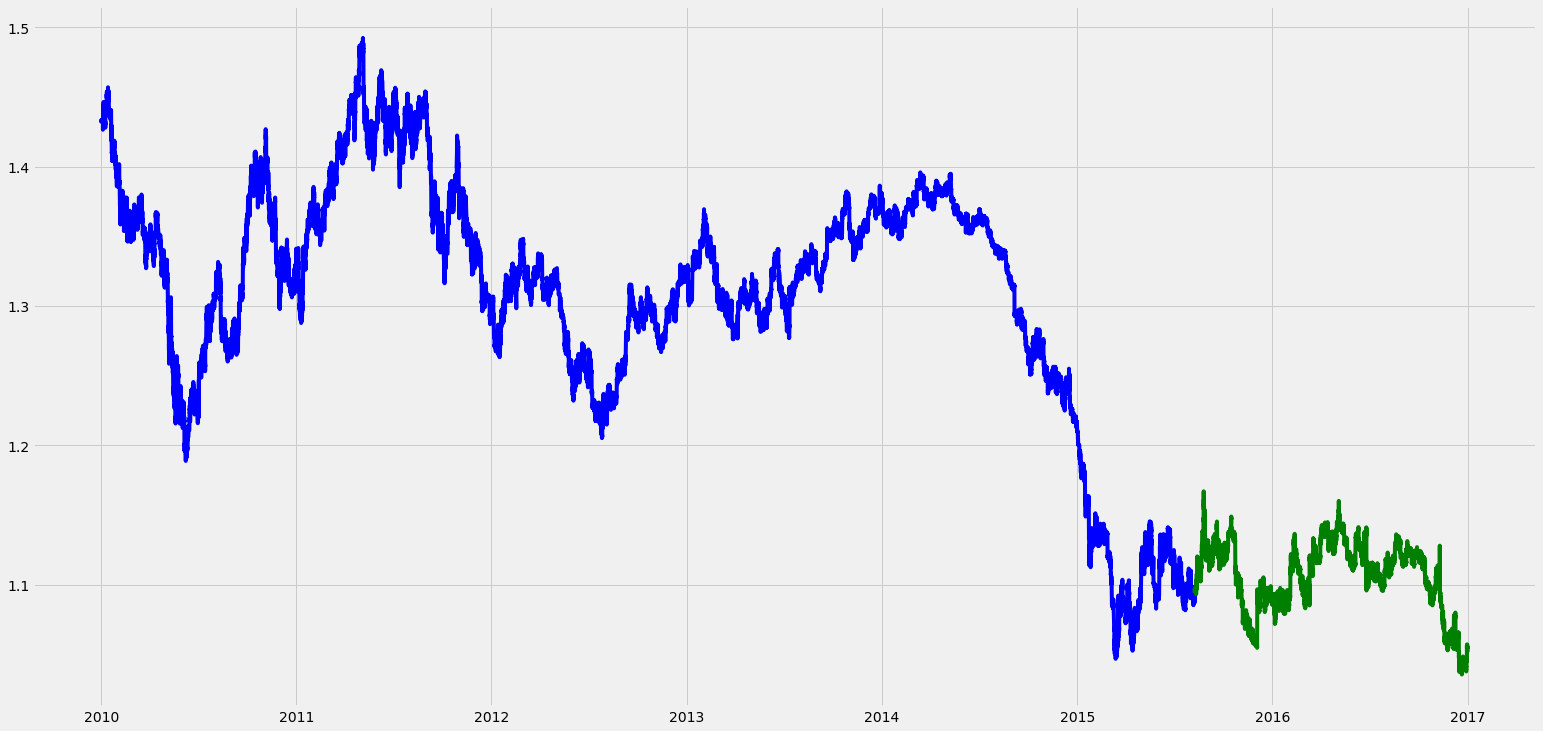

In [25]:
# using scikitlearn to split the dataset into 80% training and 20% validation datasets 
df_train, df_valid = train_test_split(df, train_size = 0.8, shuffle=False)
plt.plot(df_train['Close'], color='blue')
plt.plot(df_valid['Close'], color='green')

# Calculate max profit on each point and determine potential entry points



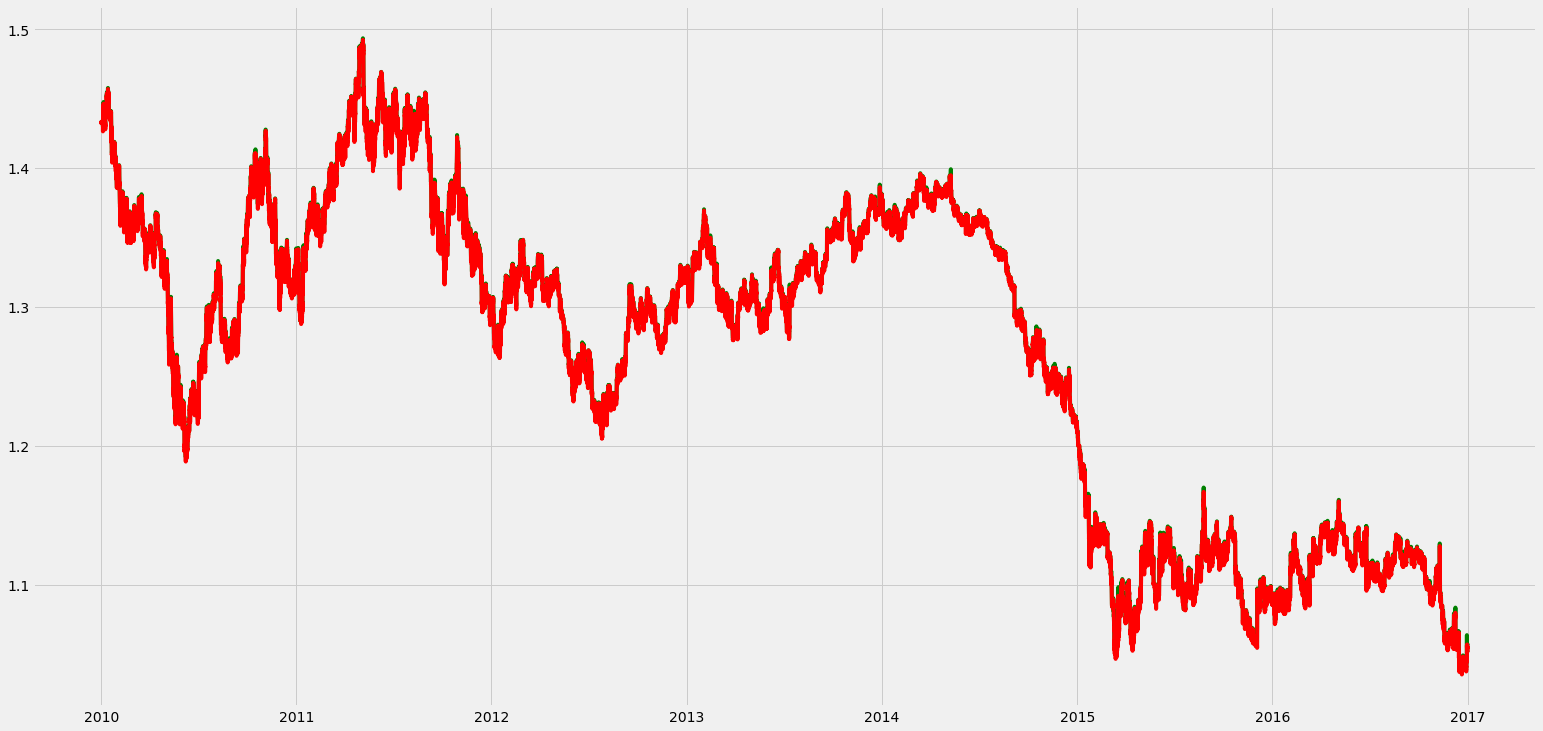

In [32]:
# Profit:Risk ratio : 2:1
target_rate = 0.002 # 0.2% of gain on buy and short positions
risk_rate = target_rate/2
safe_expected_margin = 1.5 # the profit must be 1.5*the target rate
max_duration = 8 # in periods or laggs (for example 30min* 8 = 240min = 4 hours)
# get prices
highest_prices = df['High']
lowest_prices = df['Low']

df['max_price'] = highest_prices.rolling(max_duration).max().shift(-max_duration)
df['min_price'] = lowest_prices.rolling(max_duration).min().shift(-max_duration)

    